In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

# Load dataset
dataset = pd.read_csv('kunden_einkaufszentrum.csv')

# Check if there are null or empty cells
print(dataset.isnull().sum())

# Gender replace male with 0 and female with 1
dataset['Gender'] = dataset['Gender'].map({'Male': 0, 'Female': 1})

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


C:\Users\danilo.weber\PycharmProjects\dhbw_dataScience\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Das System kann die angegebene Datei nicht finden
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\danilo.weber\PycharmProjects\dhbw_dataScience\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\danilo.weber\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\danilo.weber\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\danilo.weber\AppData\L

k=6: 69.00%
k=5: 13.00%
k=7: 17.00%
k=8: 1.00%


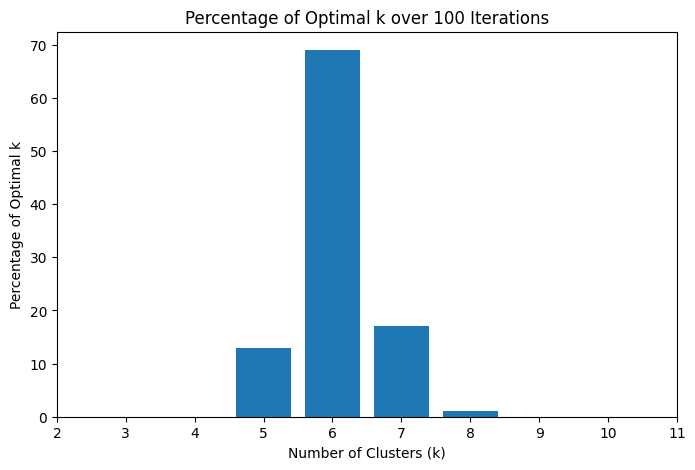

In [2]:
# Select relevant columns for clustering
data = dataset[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Define the stability analysis function
def stability_analysis(X, range_n_clusters):
    optimal_k_counts = Counter()
    for _ in range(100):  # 100 iterations
        silhouette_avgs = []
        for n_clusters in range_n_clusters:
            kmeans = KMeans(n_clusters=n_clusters, random_state=None).fit(X)
            silhouette_avgs.append(silhouette_score(X, kmeans.labels_))
        optimal_k = range_n_clusters[np.argmax(silhouette_avgs)]
        optimal_k_counts[optimal_k] += 1
    return optimal_k_counts

# Define the range of clusters
range_n_clusters = range(2, 12)

# Perform stability analysis
optimal_k_counts = stability_analysis(data.values, range_n_clusters)

# Calculate percentages
total_iterations = sum(optimal_k_counts.values())
k_percentages = {k: (count / total_iterations) * 100 for k, count in optimal_k_counts.items()}

# Print the results
for k, percentage in k_percentages.items():
    print(f"k={k}: {percentage:.2f}%")

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(k_percentages.keys(), k_percentages.values())
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Percentage of Optimal k")
plt.title("Percentage of Optimal k over 100 Iterations")
plt.xticks(range_n_clusters)
plt.show()

In [3]:
# Select the optimal number of clusters
optimal_k = max(k_percentages, key=k_percentages.get)

# Initialize variables
n_init = 100
best_inertia = float('inf')
best_seed = None

# Perform K-Means with different random seeds
for i in range(n_init):
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=i)
    kmeans.fit(data)

    # Compare inertia
    if kmeans.inertia_ < best_inertia:
        best_inertia = kmeans.inertia_
        best_seed = i

print("Best seed:", best_seed)

Best seed: 2


In [4]:
# Perform clustering with the optimal number of clusters using the best seed
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=best_seed).fit(data)

print("Final cluster centers:", kmeans.cluster_centers_)
print("Inertia:", kmeans.inertia_)


Final cluster centers: [[ 0.65789474 27.         56.65789474 49.13157895]
 [ 0.55555556 56.15555556 53.37777778 49.08888889]
 [ 0.59090909 25.27272727 25.72727273 79.36363636]
 [ 0.53846154 32.69230769 86.53846154 82.12820513]
 [ 0.42857143 41.68571429 88.22857143 17.28571429]
 [ 0.61904762 44.14285714 25.14285714 19.52380952]]
Inertia: 58348.64136331505


In [6]:
# Add cluster labels to the dataset
data['Cluster'] = kmeans.labels_

# Function to calculate descriptive statistics for each cluster
def descriptive_statistics(data):
    cluster_stats = {}
    for cluster in np.unique(data['Cluster']):
        cluster_data = data[data['Cluster'] == cluster]
        stats = cluster_data.describe().T
        stats['sum'] = cluster_data.sum()
        stats['percentage'] = (cluster_data.sum() / data.sum()) * 100
        cluster_stats[cluster] = stats
    return cluster_stats

# Calculate descriptive statistics for each cluster
cluster_stats = descriptive_statistics(data)

# Function to make clusters accessable from other files
def get_clusters():
    return data['Cluster'], kmeans.cluster_centers_

# Display descriptive statistics for each cluster in tabular format
for cluster, stats in cluster_stats.items():
    print(f"\nDescriptive statistics for Cluster {cluster}:")
    display(stats)


Descriptive statistics for Cluster 0:


,count,mean,std,min,25%,50%,75%,max,sum,percentage
Gender,38.0,0.657895,0.480783,0.0,0.0,1.0,1.00,1.0,25,22.321429
Age,38.0,27.000000,7.032742,18.0,21.0,26.5,31.75,40.0,1026,13.204633
Annual Income (k$),38.0,56.657895,9.905708,39.0,48.0,59.5,63.75,76.0,2153,17.775760
Spending Score (1-100),38.0,49.131579,7.853975,29.0,42.0,50.0,55.00,61.0,1867,18.595618
Cluster,38.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0,0.000000



Descriptive statistics for Cluster 1:


,count,mean,std,min,25%,50%,75%,max,sum,percentage
Gender,45.0,0.555556,0.502519,0.0,0.0,1.0,1.0,1.0,25,22.321429
Age,45.0,56.155556,8.543886,43.0,49.0,54.0,65.0,70.0,2527,32.522523
Annual Income (k$),45.0,53.377778,8.435016,38.0,47.0,54.0,62.0,67.0,2402,19.831572
Spending Score (1-100),45.0,49.088889,6.251626,35.0,45.0,49.0,55.0,60.0,2209,22.001992
Cluster,45.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,45,9.977827



Descriptive statistics for Cluster 2:


,count,mean,std,min,25%,50%,75%,max,sum,percentage
Gender,22.0,0.590909,0.503236,0.0,0.00,1.0,1.00,1.0,13,11.607143
Age,22.0,25.272727,5.257030,18.0,21.25,23.5,29.75,35.0,556,7.155727
Annual Income (k$),22.0,25.727273,7.566731,15.0,19.25,24.5,32.25,39.0,566,4.673052
Spending Score (1-100),22.0,79.363636,10.504174,61.0,73.00,77.0,85.75,99.0,1746,17.390438
Cluster,22.0,2.000000,0.000000,2.0,2.00,2.0,2.00,2.0,44,9.756098



Descriptive statistics for Cluster 3:


,count,mean,std,min,25%,50%,75%,max,sum,percentage
Gender,39.0,0.538462,0.505035,0.0,0.0,1.0,1.0,1.0,21,18.750000
Age,39.0,32.692308,3.728650,27.0,30.0,32.0,35.5,40.0,1275,16.409266
Annual Income (k$),39.0,86.538462,16.312485,69.0,75.5,79.0,95.0,137.0,3375,27.864927
Spending Score (1-100),39.0,82.128205,9.364489,63.0,74.5,83.0,90.0,97.0,3203,31.902390
Cluster,39.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0,117,25.942350



Descriptive statistics for Cluster 4:


,count,mean,std,min,25%,50%,75%,max,sum,percentage
Gender,35.0,0.428571,0.502096,0.0,0.0,0.0,1.0,1.0,15,13.392857
Age,35.0,41.685714,10.897305,19.0,35.0,43.0,47.5,59.0,1459,18.777349
Annual Income (k$),35.0,88.228571,16.367266,71.0,77.5,85.0,97.5,137.0,3088,25.495376
Spending Score (1-100),35.0,17.285714,10.211215,1.0,10.0,16.0,23.5,39.0,605,6.025896
Cluster,35.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0,140,31.042129



Descriptive statistics for Cluster 5:


,count,mean,std,min,25%,50%,75%,max,sum,percentage
Gender,21.0,0.619048,0.497613,0.0,0.0,1.0,1.0,1.0,13,11.607143
Age,21.0,44.142857,13.089254,19.0,35.0,45.0,53.0,67.0,927,11.930502
Annual Income (k$),21.0,25.142857,7.226934,15.0,19.0,24.0,30.0,39.0,528,4.359313
Spending Score (1-100),21.0,19.523810,12.769569,3.0,6.0,15.0,31.0,40.0,410,4.083665
Cluster,21.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0,105,23.281596
